In [2]:
import pandas as pd
from datetime import date, datetime
import os
import sys
import argparse
import random
import pickle
import shutil
import pprint
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR

from utils import maskedMSE, maskedMSETest, maskedMSEFinalTest

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from stp_r_model import STP_R_Net
from stp_g_model import STP_G_Net
from stp_gr_model import STP_GR_Net

from stp_gr_dataset import STP_GR_Dataset

import math
import time
from plot_helper import find_files, traj_plot_by_plt, x_magnitude, create_new_dir
import os.path as osp

import matplotlib.pyplot as plt
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

from tqdm import tqdm


In [3]:
# 确定所有的id

to_draw_ids = [337, 352, 353, 323, 328, 329, 331, 332, 336, 338, 339, 340, 341, 342, 343, 344, 346, 347]

# 建立每个id的单独数据集，从ngsim_data_id中寻找，保存到ngsim_single_datasets
src_dir = "/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ngsim_data_id"
dst_dir = "/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ngsim_single_datasets"

# pred_id = []

# for id in to_draw_ids:
#     f_prefix = f"stp0805am-0820am_v{id}"
#     try:
#         files = find_files(src_dir,recursive=True,prefix=f_prefix,suffix='pyg')
#         pred_id.append(id)
#     except ValueError as e:
#         print(e)
#         continue
#     out_dir = create_new_dir(dst_dir, f_prefix)
#     for f in tqdm(files,desc=f_prefix):
#         shutil.copy(f,out_dir)

# print(pred_id)
    

In [4]:
# 获得所有预测的结果
import pickle
fut_preds_dict = {}
fur_preds_traj_dict = {}
# to_draw_ids = [337, 352, 353, 323, 328, 331, 332, 336, 338, 339, 340, 341, 342, 343, 346, 347]
to_draw_ids = [337, 352, 353, 323, 328, 331, 332, 336, 338, 339, 340, 341, 342, 343, 346, 347]

start_frame,end_frame = 1826,2085
for id in to_draw_ids:
        pkl_path = f"fur_preds/fut_preds_dict_stp0805am-0820am_v{id}.pkl"
        with open(pkl_path, 'rb') as f:
                fut_preds_dict[id] =  pickle.load(f)
                frames  = [int(i.split('f')[-1]) for i in fut_preds_dict[id].keys()]
                if min(frames) > start_frame or max(frames) < end_frame:
                        print(id)
                if (len(frames)) != max(frames)-min(frames)+1:
                        print(id,len(frames),max(frames)-min(frames)+1)
                for i in range(start_frame,end_frame+1):
                        if i not in frames:
                                print(id,i)
                print(f"{id} : start frame: {min(frames)}, end_frame: {max(frames)}")
                fur_preds_traj_dict[id] = []
                for i in range(start_frame,end_frame+1):
                        frm_name = f"stp0805am-0820am_v{id}_f{i}"
                        if frm_name not in fut_preds_dict[id].keys():
                                raise ValueError(f"{id}:{i}")
                        fur_preds_traj_dict[id].append(fut_preds_dict[id][frm_name])
                

print(fur_preds_traj_dict)




337 : start frame: 1826, end_frame: 2085
352 : start frame: 1783, end_frame: 2377
353 : start frame: 1762, end_frame: 2255
323 645 657
323 : start frame: 1672, end_frame: 2328
328 : start frame: 1694, end_frame: 2352
331 : start frame: 1708, end_frame: 2373
332 523 535
332 : start frame: 1711, end_frame: 2245
336 : start frame: 1728, end_frame: 2263
338 : start frame: 1728, end_frame: 2199
339 : start frame: 1718, end_frame: 2392
340 : start frame: 1725, end_frame: 2413
341 : start frame: 1728, end_frame: 2324
342 : start frame: 1739, end_frame: 2297
343 : start frame: 1738, end_frame: 2424
346 : start frame: 1749, end_frame: 2442
347 : start frame: 1748, end_frame: 2227
{337: [tensor([[[ 8.4471e-02,  2.4543e+01],
         [ 2.5857e-02,  4.9194e+01],
         [-4.7752e-02,  7.3705e+01],
         [-8.9851e-02,  9.8620e+01],
         [-1.6212e-01,  1.2313e+02],
         [-3.0603e-01,  1.4721e+02],
         [-5.3178e-01,  1.7089e+02],
         [-8.1845e-01,  1.9627e+02],
         [-1.0024

In [5]:
# 获得所有id的历史位置
traj_csv = "data_us101/trajectories-0805am-0820am.csv"
traj_df = pd.read_csv(traj_csv)
hist_dict = {}
for id in to_draw_ids:
        hist =  traj_df[(traj_df['Frame_ID'] >= start_frame) & (traj_df['Frame_ID'] <= end_frame) & (traj_df['Vehicle_ID'] == id)][['Local_X', 'Local_Y']].values
        hist_dict[id] = hist
print(hist_dict)

{337: array([[  19.605,  806.148],
       [  19.574,  810.941],
       [  19.544,  815.771],
       [  19.515,  820.612],
       [  19.481,  825.445],
       [  19.436,  830.294],
       [  19.387,  835.162],
       [  19.313,  840.032],
       [  19.207,  844.888],
       [  19.091,  849.734],
       [  18.989,  854.584],
       [  18.935,  859.412],
       [  18.884,  864.158],
       [  18.782,  868.786],
       [  18.652,  873.322],
       [  18.634,  877.796],
       [  18.709,  882.197],
       [  18.724,  886.46 ],
       [  18.717,  890.607],
       [  18.638,  894.622],
       [  18.597,  898.598],
       [  18.63 ,  902.582],
       [  18.639,  906.584],
       [  18.649,  910.585],
       [  18.658,  914.585],
       [  18.667,  918.583],
       [  18.678,  922.588],
       [  18.687,  926.605],
       [  18.697,  930.612],
       [  18.747,  934.557],
       [  18.778,  938.36 ],
       [  18.765,  942.043],
       [  18.733,  945.58 ],
       [  18.743,  949.046],
       [

[[  5.975604  245.7139104]
 [  5.9661552 247.1748168]
 [  5.9570112 248.6470008]
 [  5.948172  250.1225376]
 [  5.9378088 251.595636 ]
 [  5.9240928 253.0736112]
 [  5.9091576 254.5573776]
 [  5.8866024 256.0417536]
 [  5.8542936 257.5218624]
 [  5.8189368 258.9989232]
 [  5.7878472 260.4772032]
 [  5.771388  261.9487776]
 [  5.7558432 263.3953584]
 [  5.7247536 264.8059728]
 [  5.6851296 266.1885456]
 [  5.6796432 267.5522208]
 [  5.7025032 268.8936456]
 [  5.7070752 270.193008 ]
 [  5.7049416 271.4570136]
 [  5.6808624 272.6807856]
 [  5.6683656 273.8926704]
 [  5.678424  275.1069936]
 [  5.6811672 276.3268032]
 [  5.6842152 277.546308 ]
 [  5.6869584 278.765508 ]
 [  5.6897016 279.9840984]
 [  5.6930544 281.2048224]
 [  5.6957976 282.429204 ]
 [  5.6988456 283.6505376]
 [  5.7140856 284.8529736]
 [  5.7235344 286.012128 ]
 [  5.719572  287.1347064]
 [  5.7098184 288.212784 ]
 [  5.7128664 289.2692208]
 [  5.7220104 290.3229144]
 [  5.7433464 291.3695976]
 [  5.7585864 292.3806192]
 

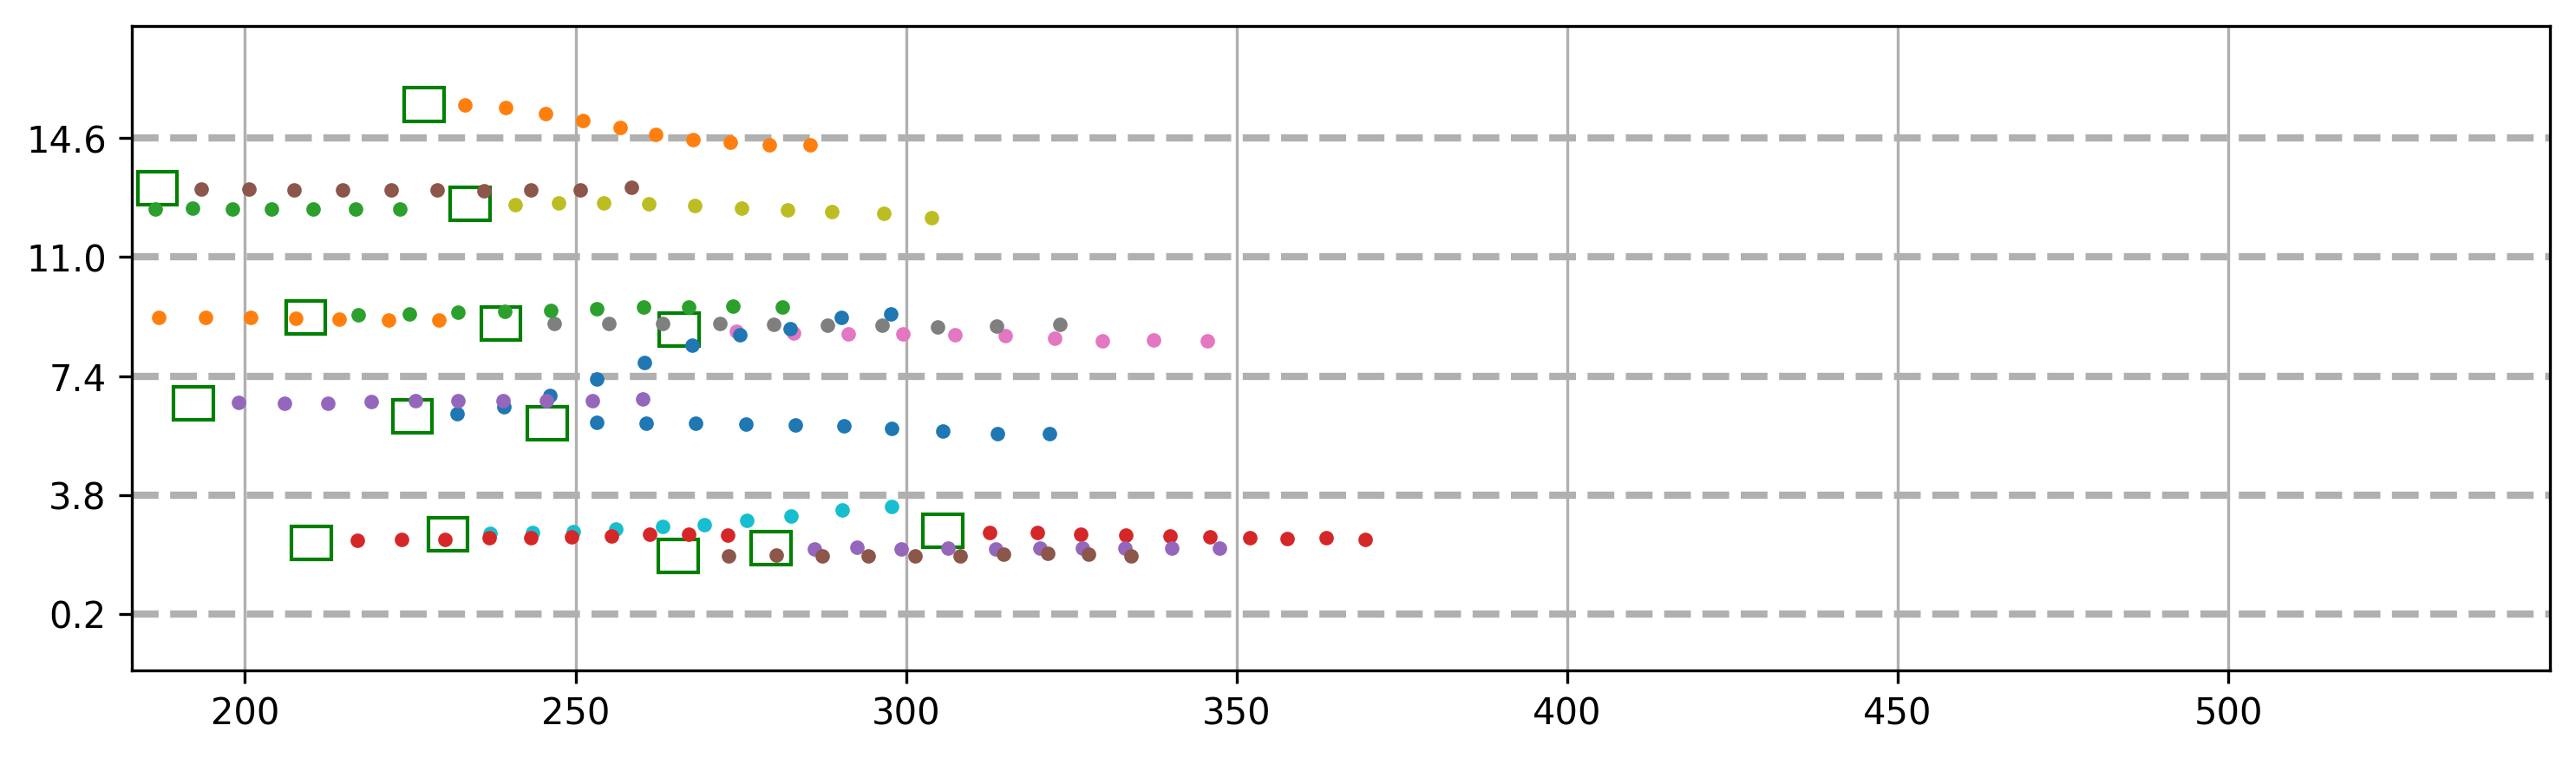

Moviepy - Building video imgs/my_animation6.mp4.
Moviepy - Writing video imgs/my_animation6.mp4



Moviepy - Done !
Moviepy - video ready imgs/my_animation6.mp4


In [18]:
# 画图
duration = 26
fig, ax = plt.subplots(figsize=(10,4),dpi=300)
fig.set_tight_layout(True)
ax.set_aspect(5)
# plt.ylim(-1.2, 13.2)
major_ticks = np.arange(0.2, 18, 3.6)
# minor_ticks = np.arange(-9, 9, 1.8)
# ax.set_yticks(minor_ticks, minor=True)

hist_id = hist_dict[337] *  0.3048
fut_id = fur_preds_traj_dict[337][0]*  0.3048

print(hist_id)
print(fut_id)
def make_frame(t):
    # print(t)
    t = int(10*t)
    ax.clear()
    # plt.clear()
    for id in to_draw_ids:
        hist_id = hist_dict[id] *  0.3048
        fut_id = fur_preds_traj_dict[id][t][0]*  0.3048
        ax.plot(hist_id[t][1]+fut_id[:, 1], hist_id[t][0]+fut_id[:, 0], '.')
        
        rectangle = plt.Rectangle((hist_id[t][1]-3,hist_id[t][0]-0.5), 6, 1,fc=None,ec="green",fill=False)
        ax.add_patch(rectangle)
        # ax.plot(hist_id[t-3:t][:,1],hist_id[t-3:t][:,0],'ob')
        # ax.plot(hist_id[t][:,1],hist_id[t][:,0],'ob')
        # for i in range(hists.shape[0]):
        #     if i == 0:
        #         ax.plot(hists[i,t-3:t,1],hists[i,t-3:t,0],'ob',alpha=0.3)
        #         ax.plot(hists[i,t,1],hists[i,t,0],'ob')
        #     else:
        #         ax.plot(hists[i,t-3:t,1],hists[i,t-3:t,0],'ok',alpha=0.3)
        #         ax.plot(hists[i,t,1],hists[i,t,0],'ok')
    ax.set_ylim(-1.5, 18)
    ax.set_xlim(600* 0.3048, 1800* 0.3048)
    ax.set_yticks(major_ticks)
    ax.grid(axis='y', linestyle='--', linewidth=2, which='major')
    ax.grid(axis='x')
    plt.show()
    return mplfig_to_npimage(fig)
# make_frame(10)
animation = VideoClip(make_frame, duration=duration)
animation.write_videofile("imgs/my_animation6.mp4", fps=10)